In [1]:
import scipy
import numpy as np
import networkx as nx
import ot
import time
import multiprocessing as mp
from tqdm import tqdm, trange
import torch
import cvxpy as cp
import torch.nn as nn
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt
from dataset import *
from models import *
import h5py

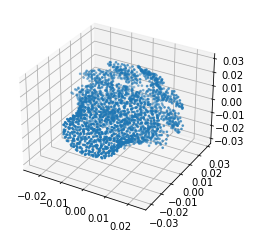

In [3]:
# Load testing data

filename = '/data/sam/modelnet/data/modelnet40_ply_hdf5_2048/ply_data_train1.h5'
dataset = None
labels = None
with h5py.File(filename,'r') as h5f: 
    dataset = h5f['data'][:]
    labels = h5f['label'][:]
    
dataset = dataset - np.expand_dims(np.mean(dataset, axis=0), 0)  # center
dist = np.max(np.sqrt(np.sum(dataset ** 2, axis=1)), 0)
dataset = dataset / dist  # scale

f = open('/data/sam/modelnet/data/shape_names.txt')
lbl_names = f.readlines()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(dataset[208][:, 0], dataset[208][:, 1], dataset[208][:, 2], s=3)

In [4]:
Ps, Qs, dists = build_multiple_item_dataset(dataset, items=[2047, 1040], max_pcd=200, train=False)
Ps = Ps.tolist()
Qs = Qs.tolist()

100%|██████████| 200/200 [00:00<00:00, 272534.37it/s]
/home/sam/siamese-metric-learning/dataset.py:121: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ps = np.array(Ps)[permutation]
/home/sam/siamese-metric-learning/dataset.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ps = np.array(Ps)[permutation]
/home/sam/siamese-metric-learning/dataset.py:122: FutureWarn

In [5]:
P_test = Ps
Q_test = Qs
dists_test = dists

In [7]:
# load non-final mlp models
from train import *
device = torch.device('cpu')
in_dim = 3
h_out = [200, 300]
h_layers = [6, 8]
g_out = [1]
g_layers = [1]
models = []
# (h_out, h_layers, g_out, g_layers)
model_params = []
for h in h_out:
    for hl in h_layers:
        for g in g_out:
            for gl in g_layers:
                model_params.append((h, hl, g, gl))
                model_name = generate_name(in_dim, h, g, hl, gl, False, 'sigmoid')
                PATH = '/data/sam/modelnet/models/siamese/tr-{modelname}.pt'.format(modelname=model_name)
                model = PointNetLearner(in_dim, h, g, num_h_layers=hl, 
                            num_g_layers=gl,final_h_layers = 10, final_mlp=False, activation='sigmoid')
                model.load_state_dict(torch.load(PATH, map_location=device))
                models.append(model)
 

In [8]:
all_results = []
average_errors = []
for k in trange(len(models)):
    model = models[k]
    results = []
    model.eval()
    timing = []
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        dist = dists_test[i]
        pvec = model.get_embedding(P).detach().numpy()
        qvec = model.get_embedding(Q).detach().numpy()
        #print(np.linalg.norm(pvec - qvec, ord=1), dist)
        results.append(abs(np.linalg.norm(pvec - qvec, ord=2)- dist)/dist)
    all_results.append(results)
    avg_error = np.average(results)
    std = np.std(results)
    average_errors.append(avg_error)
    print("Model index:", k ,"Model parameters:", model_params[k], "Average error:", avg_error, "std. dev:", std )
print("Lowest AVERAGE ERROR:", np.argmin(average_errors))

 25%|██▌       | 1/4 [00:04<00:14,  4.79s/it]

Model index: 0 Model parameters: (200, 6, 1, 1) Average error: 0.8849279641788756 std. dev: 2.292551073950091


 50%|█████     | 2/4 [00:09<00:09,  4.87s/it]

Model index: 1 Model parameters: (200, 8, 1, 1) Average error: 1.7561552884113671 std. dev: 7.71077489660228


 75%|███████▌  | 3/4 [00:15<00:05,  5.48s/it]

Model index: 2 Model parameters: (300, 6, 1, 1) Average error: 3.9710834106230117 std. dev: 17.3819469168155


100%|██████████| 4/4 [00:23<00:00,  5.96s/it]

Model index: 3 Model parameters: (300, 8, 1, 1) Average error: 7.425828756513349 std. dev: 31.454274031498272
Lowest AVERAGE ERROR: 0


[[ 1.         -0.11299448]
 [-0.11299448  1.        ]]


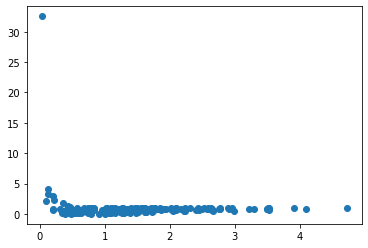

In [9]:
best_index = 0
best_result = all_results[best_index]
plt.scatter(dists_test, best_result)
r = np.corrcoef(dists_test,best_result)
print(r)

In [12]:
# load final mlp models
from train import *
device = torch.device('cpu')
in_dim = 3
h_out = [60]
h_layers = [6, 8, 10]
g_out = [10, 20, 30]
g_layers = [2, 3]
models = []
# (h_out, h_layers, g_out, g_layers)
model_params = []
for h in h_out:
    for hl in h_layers:
        for g in g_out:
            for gl in g_layers:
                model_params.append((h, hl, g, gl))
                model_name = generate_name(in_dim, h, g, hl, gl, True, 'sigmoid')
                PATH = '/data/sam/modelnet/models/mlp/{modelname}'.format(modelname=model_name)
                model = PointNetLearner(in_dim, h, g, num_h_layers=hl, 
                            num_g_layers=gl, final_mlp=False, activation='sigmoid')
                model.load_state_dict(torch.load(PATH, map_location=device))
                models.append(model)

In [14]:
all_results = []
average_errors = []
result_dictionary = {}
for params in model_params:
    hwidth = params[0]
    hdepth = params[1]
    result_dictionary[(hwidth, hdepth)] = []
for k in trange(len(models)):
    model = models[k]
    results = []
    model.eval()
    for i in range(len(P_test)):
        P = P_test[i].to(device)
        Q = Q_test[i].to(device)
        dist = dists_test[i]
        estimate = model.get_full_result(P, Q).detach().cpu().numpy()
        results.append(abs((1-estimate)- dist)/dist)
    all_results.append(results)
    avg_error = np.average(results)
    std = np.std(results)
    average_errors.append(avg_error)
    result_dictionary[(model_params[k][0], model_params[k][1])].append((model_params[k][2], model_params[k][3], avg_error, std))
    print("Model index:", k ,"Model parameters:", model_params[k], "Avg. error:", avg_error, "std:", std)
print("Lowest AVERAGE ERROR:", np.argmin(average_errors))

  6%|▌         | 1/18 [00:09<02:43,  9.65s/it]

Model index: 0 Model parameters: (60, 6, 10, 2) Avg. error: 0.6900224 std: 1.3571558


 11%|█         | 2/18 [00:19<02:34,  9.68s/it]

Model index: 1 Model parameters: (60, 6, 10, 3) Avg. error: 0.63765043 std: 0.5054855


 17%|█▋        | 3/18 [00:27<02:17,  9.14s/it]

Model index: 2 Model parameters: (60, 6, 20, 2) Avg. error: 0.63998914 std: 0.49725768


 22%|██▏       | 4/18 [00:34<01:53,  8.13s/it]

Model index: 3 Model parameters: (60, 6, 20, 3) Avg. error: 0.6231179 std: 0.5707178


 28%|██▊       | 5/18 [00:42<01:44,  8.02s/it]

Model index: 4 Model parameters: (60, 6, 30, 2) Avg. error: 0.62086695 std: 0.5867084


 33%|███▎      | 6/18 [00:46<01:21,  6.82s/it]

Model index: 5 Model parameters: (60, 6, 30, 3) Avg. error: 0.62463033 std: 0.5626735


 39%|███▉      | 7/18 [00:57<01:27,  7.95s/it]

Model index: 6 Model parameters: (60, 8, 10, 2) Avg. error: 0.60873526 std: 0.9490615


 44%|████▍     | 8/18 [01:07<01:27,  8.75s/it]

Model index: 7 Model parameters: (60, 8, 10, 3) Avg. error: 0.6044754 std: 0.8002342


 50%|█████     | 9/18 [01:18<01:24,  9.39s/it]

Model index: 8 Model parameters: (60, 8, 20, 2) Avg. error: 0.61210966 std: 0.9853138


 56%|█████▌    | 10/18 [01:32<01:26, 10.81s/it]

Model index: 9 Model parameters: (60, 8, 20, 3) Avg. error: 0.6210037 std: 0.5826899


 61%|██████    | 11/18 [01:44<01:18, 11.22s/it]

Model index: 10 Model parameters: (60, 8, 30, 2) Avg. error: 0.634832 std: 0.51654935


 67%|██████▋   | 12/18 [01:55<01:06, 11.11s/it]

Model index: 11 Model parameters: (60, 8, 30, 3) Avg. error: 0.6230186 std: 0.5706797


 72%|███████▏  | 13/18 [02:09<01:00, 12.14s/it]

Model index: 12 Model parameters: (60, 10, 10, 2) Avg. error: 0.61802286 std: 0.60364836


 78%|███████▊  | 14/18 [02:26<00:53, 13.43s/it]

Model index: 13 Model parameters: (60, 10, 10, 3) Avg. error: 0.6062986 std: 0.7291748


 83%|████████▎ | 15/18 [02:37<00:38, 12.94s/it]

Model index: 14 Model parameters: (60, 10, 20, 2) Avg. error: 0.6524127 std: 1.2086781


 89%|████████▉ | 16/18 [02:46<00:23, 11.53s/it]

Model index: 15 Model parameters: (60, 10, 20, 3) Avg. error: 0.6342294 std: 0.5190567


 94%|█████████▍| 17/18 [03:02<00:12, 12.97s/it]

Model index: 16 Model parameters: (60, 10, 30, 2) Avg. error: 0.6171936 std: 0.6100507


100%|██████████| 18/18 [03:15<00:00, 10.87s/it]

Model index: 17 Model parameters: (60, 10, 30, 3) Avg. error: 0.61624074 std: 0.6163368
Lowest AVERAGE ERROR: 7


In [16]:
mlp_testerr = all_results